/software/slurm/spackages/linux-rocky8-x86_64/gcc-12.2.0/anaconda3-2023.09-0-3mhml42fa64byxqyd5fig5tbih625dp2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


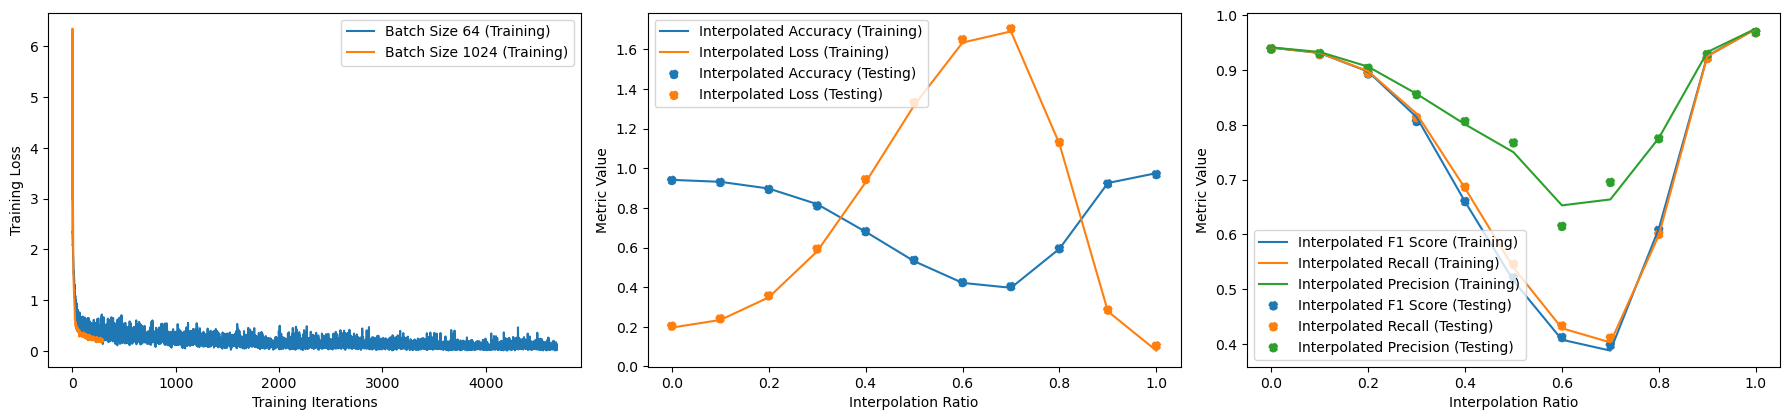

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score

# Define the neural network architecture (same as before)
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Function to train a model
def train_model(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    train_loss = []
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
    return train_loss

# Function to evaluate a model on a dataset
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            total_loss += criterion(outputs, labels).item()
    accuracy = correct / total
    return accuracy, total_loss / len(data_loader)

# Function to evaluate a model on a dataset and return precision, recall, and F1 score
def evaluate_model_metrics(model, data_loader):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.numpy())
            all_predictions.extend(predicted.numpy())

    all_labels = torch.tensor(all_labels)
    all_predictions = torch.tensor(all_predictions)

    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')

    return precision, recall, f1

# Linear interpolation function
def linear_interpolation(model1, model2, alpha):
    new_model = SimpleNN()
    new_state_dict = {}
    for key in model1.state_dict():
        new_state_dict[key] = alpha * model1.state_dict()[key] + (1 - alpha) * model2.state_dict()[key]
    new_model.load_state_dict(new_state_dict)
    return new_model

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Set up data loaders
batch_size_m1 = 64
batch_size_m2 = 1024
train_loader_m1 = DataLoader(mnist_train, batch_size=batch_size_m1, shuffle=True)
train_loader_m2 = DataLoader(mnist_train, batch_size=batch_size_m2, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=100, shuffle=False)

# Define the models
model_m1 = SimpleNN()
model_m2 = SimpleNN()

# Define the criterion and optimizers
criterion = nn.CrossEntropyLoss()
optimizer_m1 = optim.Adam(model_m1.parameters(), lr=1e-3)
optimizer_m2 = optim.Adam(model_m2.parameters(), lr=1e-2)

# Train the models
train_loss_m1 = train_model(model_m1, train_loader_m1, criterion, optimizer_m1)
train_loss_m2 = train_model(model_m2, train_loader_m2, criterion, optimizer_m2)

# Evaluate the models on the test set
accuracy_m1, _ = evaluate_model(model_m1, test_loader)
accuracy_m2, _ = evaluate_model(model_m2, test_loader)

# Linear interpolation and evaluation for different interpolation ratios
interpolation_ratios = torch.linspace(0, 1, 11)  # 11 points from 0 to 1
interpolated_accuracies_train = []
interpolated_losses_train = []
interpolated_f1_scores_train = []
interpolated_recalls_train = []
interpolated_precisions_train = []

interpolated_accuracies_test = []
interpolated_losses_test = []
interpolated_f1_scores_test = []
interpolated_recalls_test = []
interpolated_precisions_test = []

for alpha in interpolation_ratios:
    interpolated_model = linear_interpolation(model_m1, model_m2, alpha)

    # Evaluate on both training and test sets
    accuracy_train, loss_train = evaluate_model(interpolated_model, train_loader_m1)
    accuracy_test, loss_test = evaluate_model(interpolated_model, test_loader)

    precision_train, recall_train, f1_train = evaluate_model_metrics(interpolated_model, train_loader_m1)
    precision_test, recall_test, f1_test = evaluate_model_metrics(interpolated_model, test_loader)

    interpolated_accuracies_train.append(accuracy_train)
    interpolated_losses_train.append(loss_train)
    interpolated_f1_scores_train.append(f1_train)
    interpolated_recalls_train.append(recall_train)
    interpolated_precisions_train.append(precision_train)

    interpolated_accuracies_test.append(accuracy_test)
    interpolated_losses_test.append(loss_test)
    interpolated_f1_scores_test.append(f1_test)
    interpolated_recalls_test.append(recall_test)
    interpolated_precisions_test.append(precision_test)

# Plotting
plt.figure(figsize=(18, 8))

# Plot training loss
plt.subplot(2, 3, 1)
plt.plot(train_loss_m1, label='Batch Size 64 (Training)')
plt.plot(train_loss_m2, label='Batch Size 1024 (Training)')
plt.xlabel('Training Iterations')
plt.ylabel('Training Loss')
plt.legend()

# Plot interpolated accuracy and loss (training and testing)
plt.subplot(2, 3, 2)
plt.plot(interpolation_ratios.numpy(), interpolated_accuracies_train, label='Interpolated Accuracy (Training)')
plt.plot(interpolation_ratios.numpy(), interpolated_losses_train, label='Interpolated Loss (Training)')
plt.scatter(interpolation_ratios.numpy(), interpolated_accuracies_test, linestyle='--', label='Interpolated Accuracy (Testing)')
plt.scatter(interpolation_ratios.numpy(), interpolated_losses_test, linestyle='--', label='Interpolated Loss (Testing)')
plt.xlabel('Interpolation Ratio')
plt.ylabel('Metric Value')
plt.legend()

# Plot interpolated F1 score, recall, and precision (training and testing)
plt.subplot(2, 3, 3)
plt.plot(interpolation_ratios.numpy(), interpolated_f1_scores_train, label='Interpolated F1 Score (Training)')
plt.plot(interpolation_ratios.numpy(), interpolated_recalls_train, label='Interpolated Recall (Training)')
plt.plot(interpolation_ratios.numpy(), interpolated_precisions_train, label='Interpolated Precision (Training)')
plt.scatter(interpolation_ratios.numpy(), interpolated_f1_scores_test, linestyle='--', label='Interpolated F1 Score (Testing)')
plt.scatter(interpolation_ratios.numpy(), interpolated_recalls_test, linestyle='--', label='Interpolated Recall (Testing)')
plt.scatter(interpolation_ratios.numpy(), interpolated_precisions_test, linestyle='--', label='Interpolated Precision (Testing)')
plt.xlabel('Interpolation Ratio')
plt.ylabel('Metric Value')
plt.legend()

plt.tight_layout()
plt.show()
